In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

import matplotlib as mpl

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,12)))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)

runstr='Dry'
dftab=pd.read_pickle('dfs/df_run_02_dry_delta_tab.pkl')
df=pd.read_pickle('dfs/df_run_02_dry.pkl')

runstr='Wet'
dftab=pd.read_pickle('dfs/df_run_02_land_delta_tab.pkl')
df=pd.read_pickle('dfs/df_run_02_land.pkl')

In [241]:
def fit_thalf(t,y,ax=False):
    ly = np.log(y)
    K, A_log = np.polyfit(t, ly, 1)
    A = np.exp(A_log)
    thalf=-np.log(2)/K
    yf=np.exp(A_log+t*K)
    
    if ax:
        ax.plot(t*24,y)
        ax.plot(t*24,yf,'--')
        ax.grid(True)
        ax.set_title('t$_{lf}$='+str(tlf))
        ax.set_xlabel('t (h)')
        ax.set_ylabel('Pdef (pa)')
        ax.set_xlim((0,12))
        ax.set_ylim((10,110))
        
    return(thalf)

def get_a_coeff(dft,tlf,tmin=1,tmax=3,ax=False):
    tal=dft['t']-dft['tlf']
    dft=dft[dft.tlf.eq(tlf) & dft.r.gt(5)]
    dft=dft.query('r < rV10max*1.0')
    dft=dft.query('t - tlf < ' + str(tmax) +'/24.')
    dft=dft.query('t - tlf > ' + str(tmin) +'/24.')
#     dft=dft.query('Vrcol > 0')

    m,c=np.polyfit(dft.dPdr,dft.Vrcol,1)
    
    if ax:
        ax.plot(dft.dPdr,dft.Vrcol,'.')
        ax.plot(dft.dPdr,m*dft.dPdr+c,lw=2)
        ax.set_xlim((0,0.25))
#         ax.set_ylim((0,0.045))
        ax.set_title('t$_{lf}$='+str(tlf))
        ax.grid(True)
        ax.set_xlabel('dPdr')
        ax.set_ylabel('Vrcol')
    return(m)

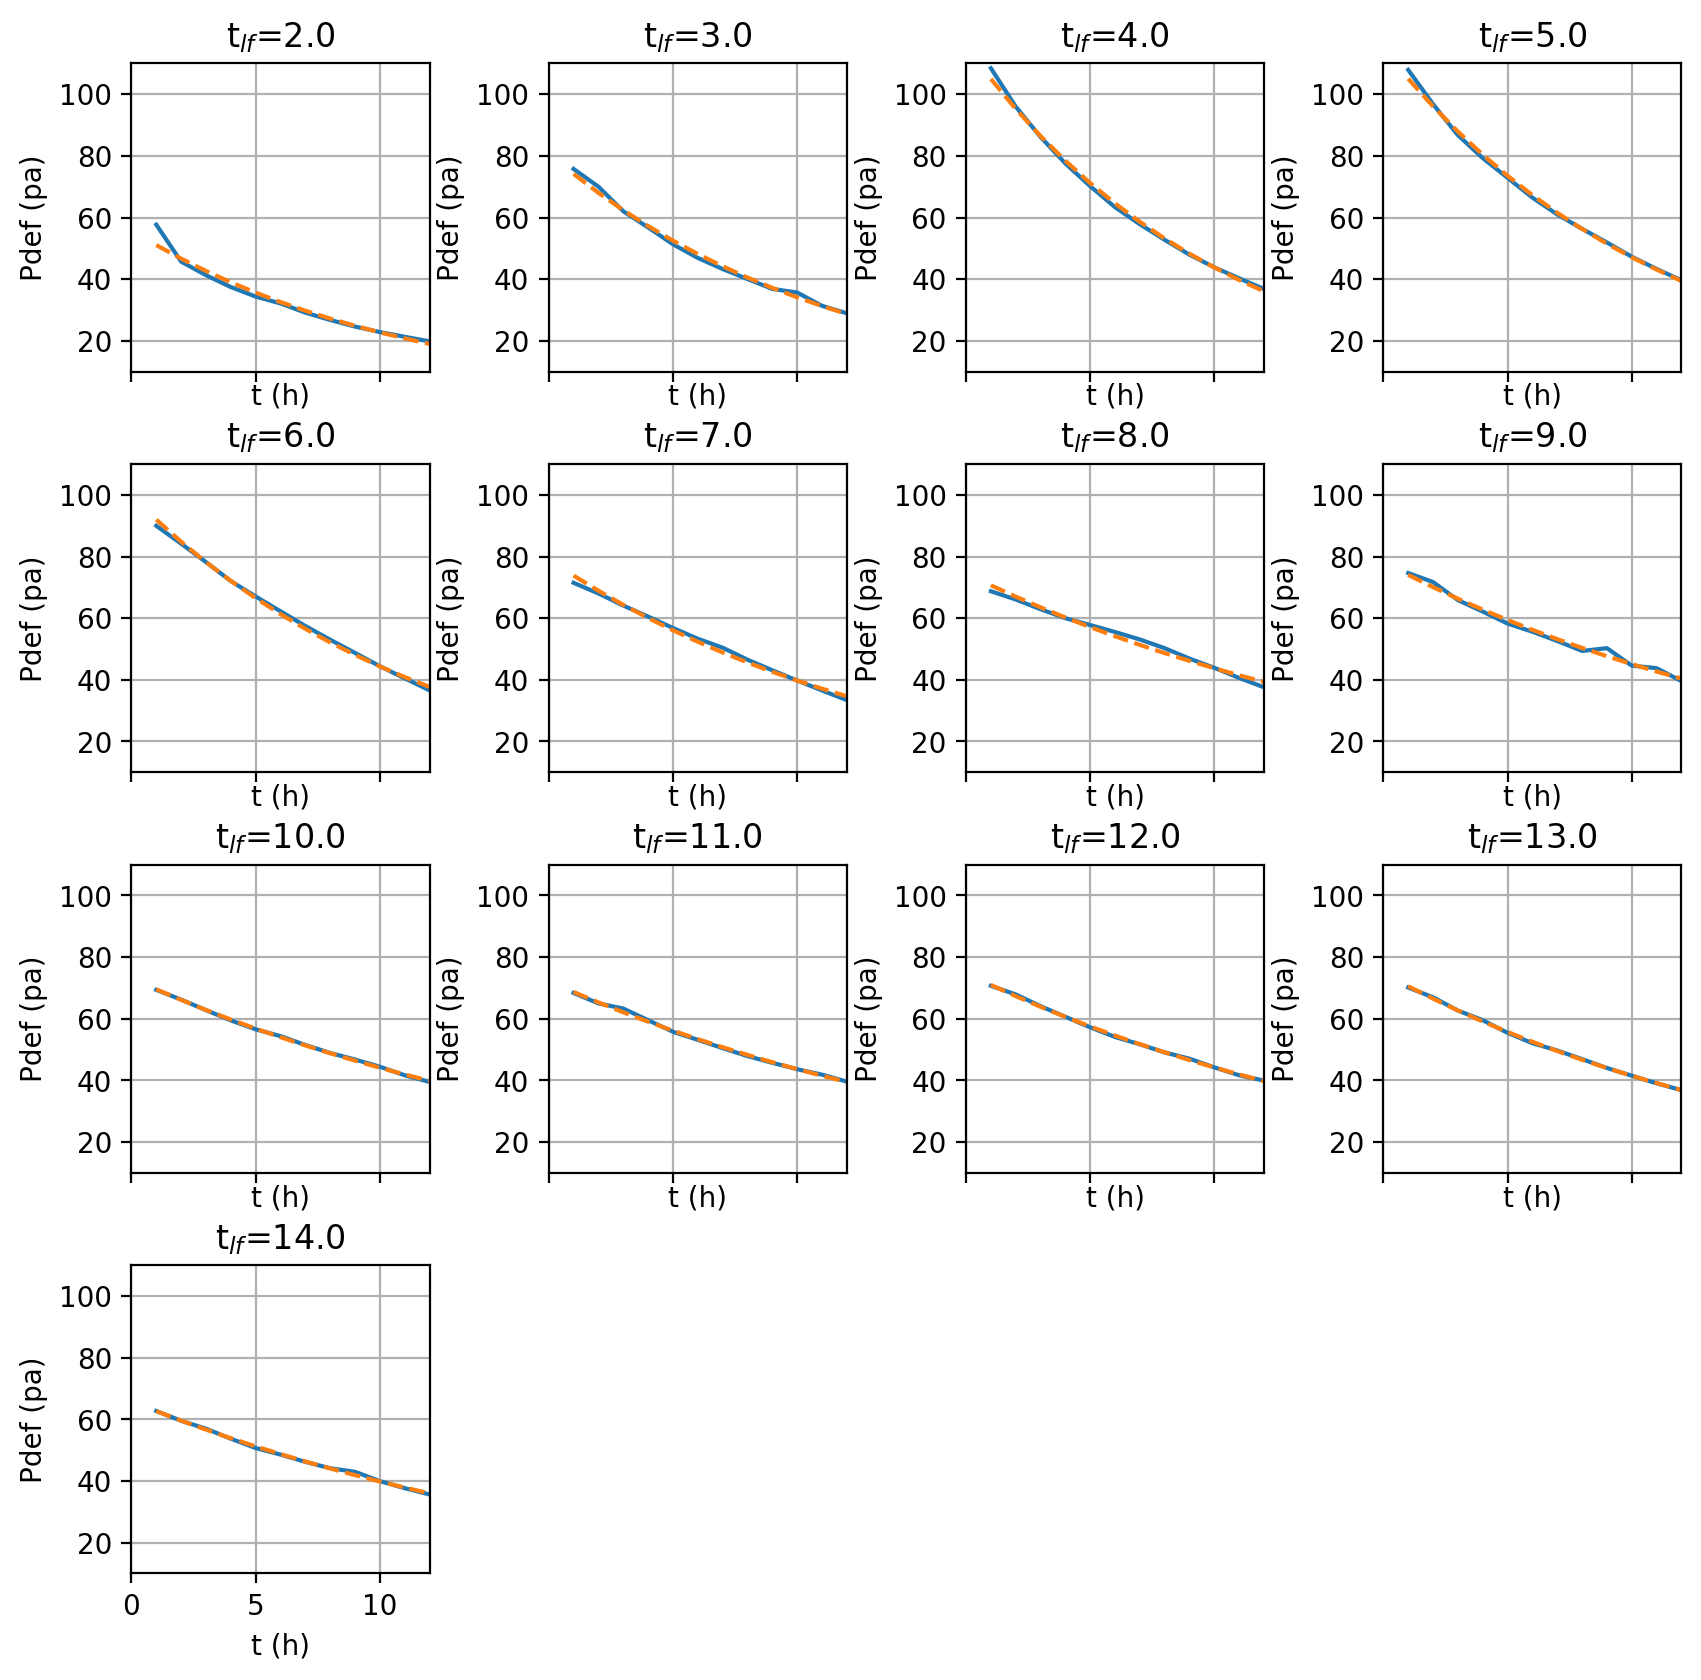

In [242]:
fig,axs=plt.subplots(4,4,sharex=True,dpi=200,figsize=(10,10))
plt.subplots_adjust(hspace=0.3,wspace=0.4)
tlfs=df.tlf.unique()
thP=[]
thV=[]
Rmax0=[]
Pmin0=[]
Vmax0=[]
Pe=1016
t0=1
tmax=12
for n,tlf in enumerate(tlfs):
    dftab_f=dftab[dftab.tlf.eq(tlf)]
    df_f=df[df.tlf.eq(tlf)]
    t=df_f.t-df_f.tlf
    Pmin=df_f.Pmin
    Vmax=df_f.V10max
    Rmax0.append(np.mean(df_f.rV10max.head(6)))
    Vmax0.append(np.mean(df_f.V10max.head(1)))
    Pmin0.append(np.mean(df_f.Pmin.head(1)))
    thP.append(24*fit_thalf(t[t0:tmax+1],Pe-Pmin[t0:tmax+1],ax=axs.flat[n]))
    thV.append(24*fit_thalf(t[t0:tmax+1],Vmax[t0:tmax+1],ax=False))
    
for ax in axs.flat[n+1:]:
    ax.axis('off')
    

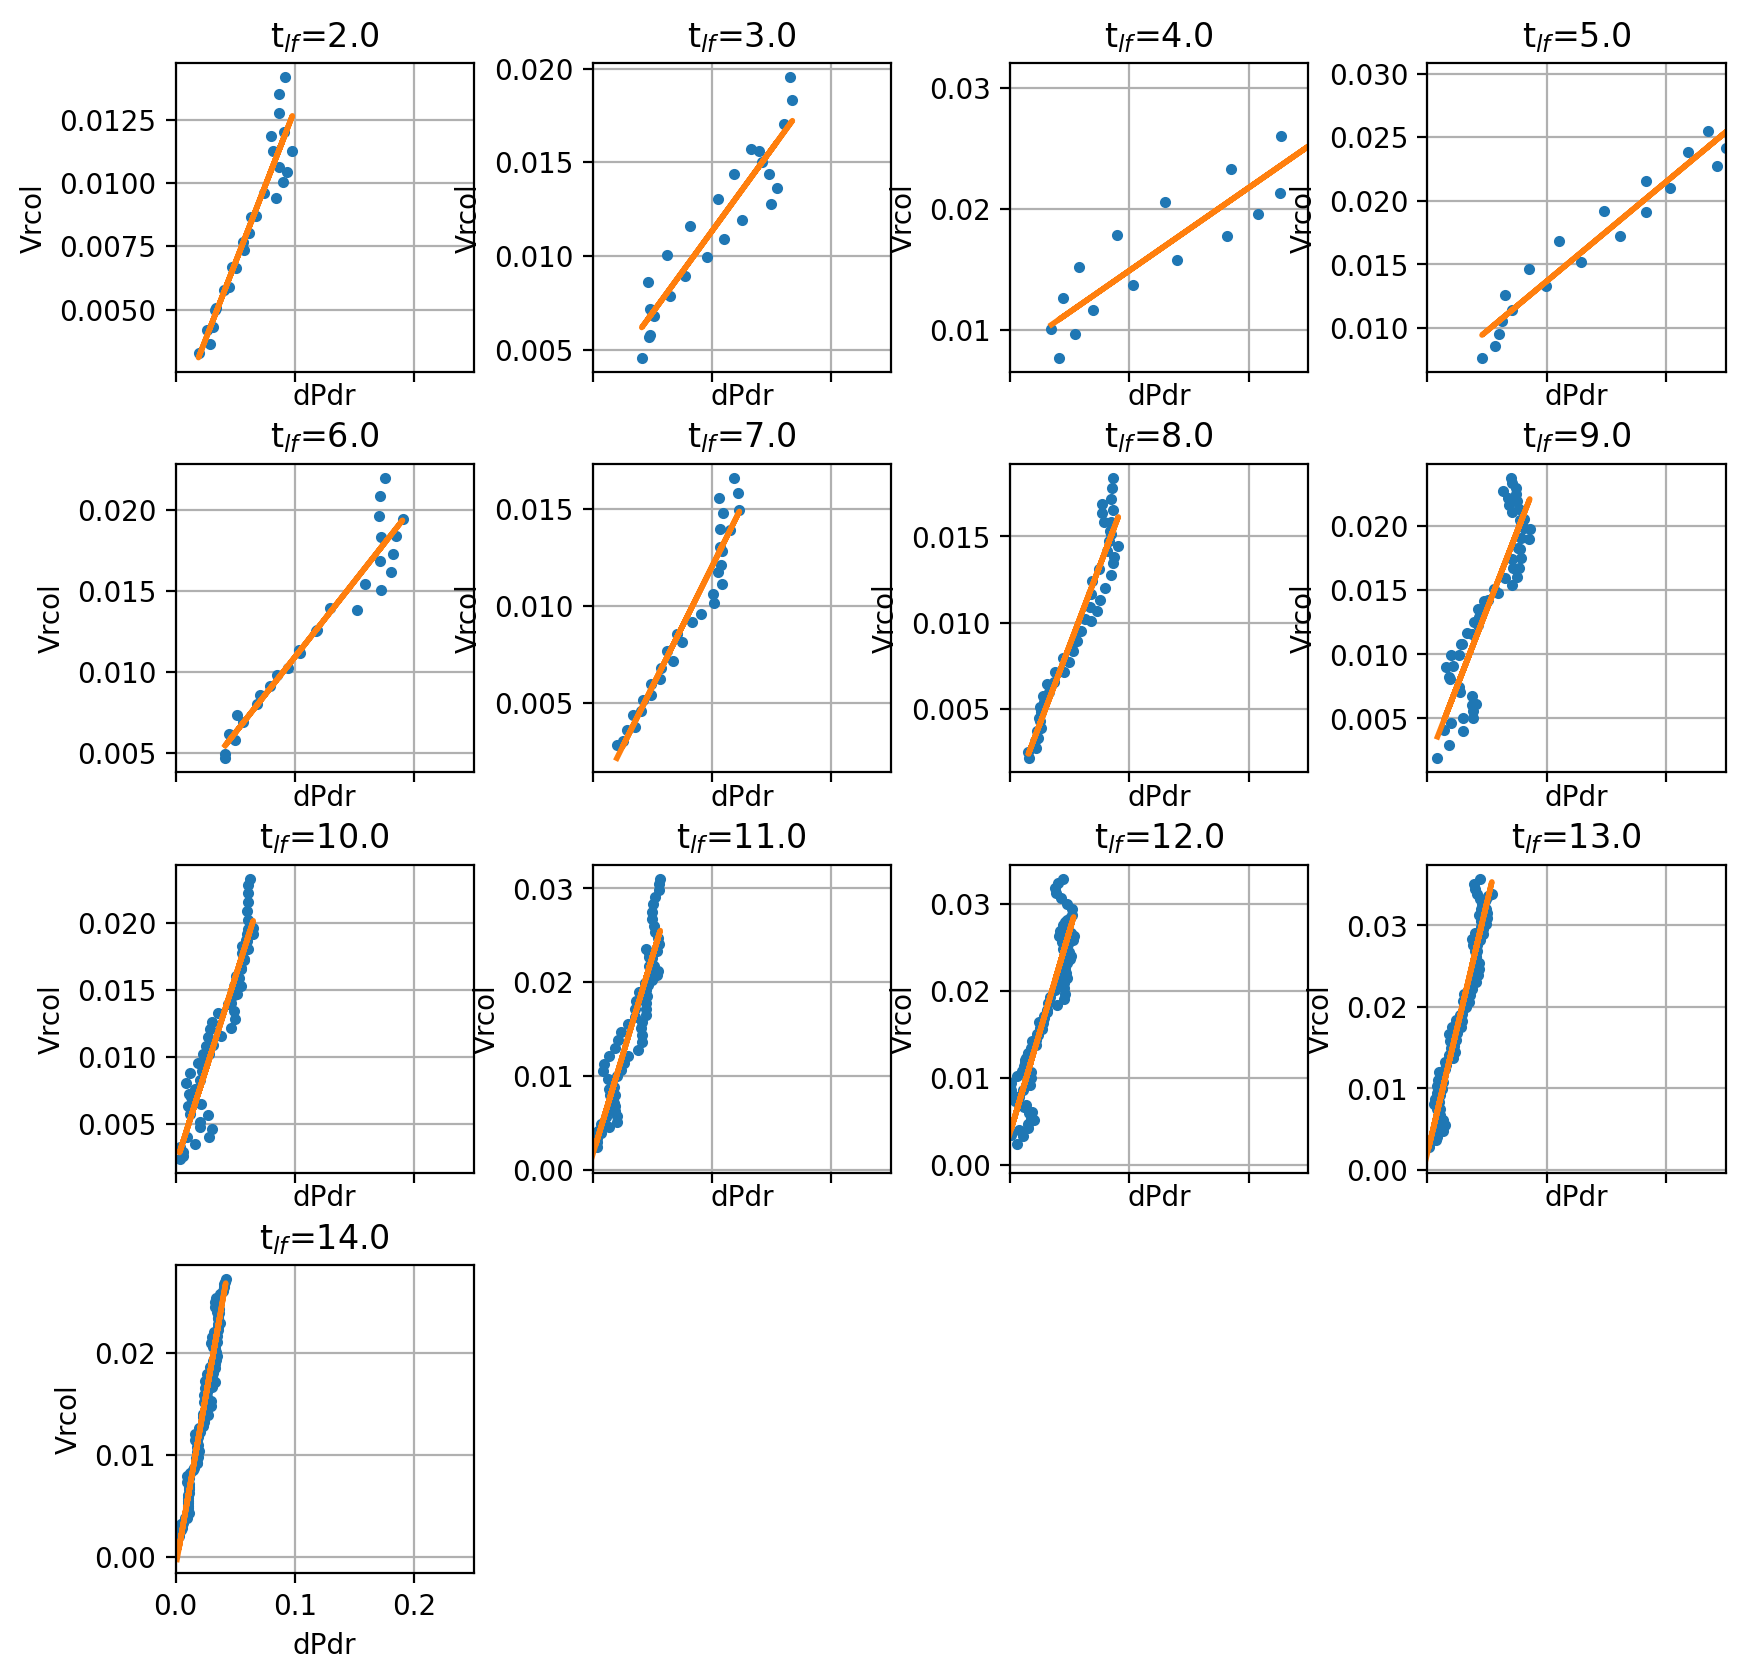

In [243]:
fig,axs=plt.subplots(4,4,sharex=True,dpi=200,figsize=(10,10))
plt.subplots_adjust(hspace=0.3,wspace=0.4)
a=[]
for n,tlf in enumerate(tlfs):
    a.append(get_a_coeff(dftab,tlf,ax=axs.flat[n],tmin=1,tmax=3))
for ax in axs.flat[n+1:]:
    ax.axis('off')

In [244]:
tlfs=df.tlf.unique()

def calc_thalf(rmax,a,Pe,P0):
    return(rmax**2/(2*a*Pe)*np.log(1+Pe/(Pe-P0)))

tha=[calc_thalf(Rmax*1000,a,Pe*100,Pmin*100)/(60*60) for Rmax,a,Pmin in zip (Rmax0,a,Pmin0)]

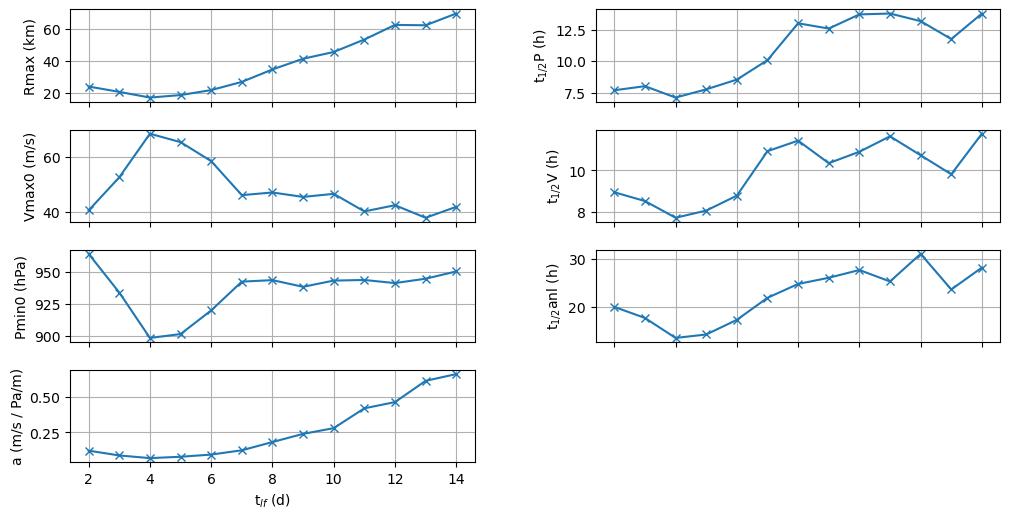

In [245]:
dd=[{'y': Rmax0, 'yl': 'Rmax (km)'},
    {'y': Vmax0, 'yl': 'Vmax0 (m/s)'},
    {'y': Pmin0, 'yl':  'Pmin0 (hPa)'},
    {'y': a,     'yl': 'a (m/s / Pa/m)'},
    {'y': thP,   'yl': 't$_{1/2}$P (h)'},
    {'y': thV,   'yl': 't$_{1/2}$V (h)'},
    {'y': tha,   'yl': 't$_{1/2}$anl (h)'},
   ]

def plot_ts(ax,d):
    ax.plot(tlfs,d['y'],'x-')
    ax.grid(True)
    ax.set_ylabel(d['yl'])

fig,axs=plt.subplots(4,2,sharex=True,dpi=100,figsize=(12,6))
plt.subplots_adjust(hspace=0.3,wspace=0.3)
axsf=axs.flatten(order='F')
for ax,d in zip(axsf,dd):
    plot_ts(ax,d)
for c in range(axs.shape[1]):
    axs[-1,c].set_xlabel('t$_{lf}$ (d)') 
axs.flat[-1].axis('off');

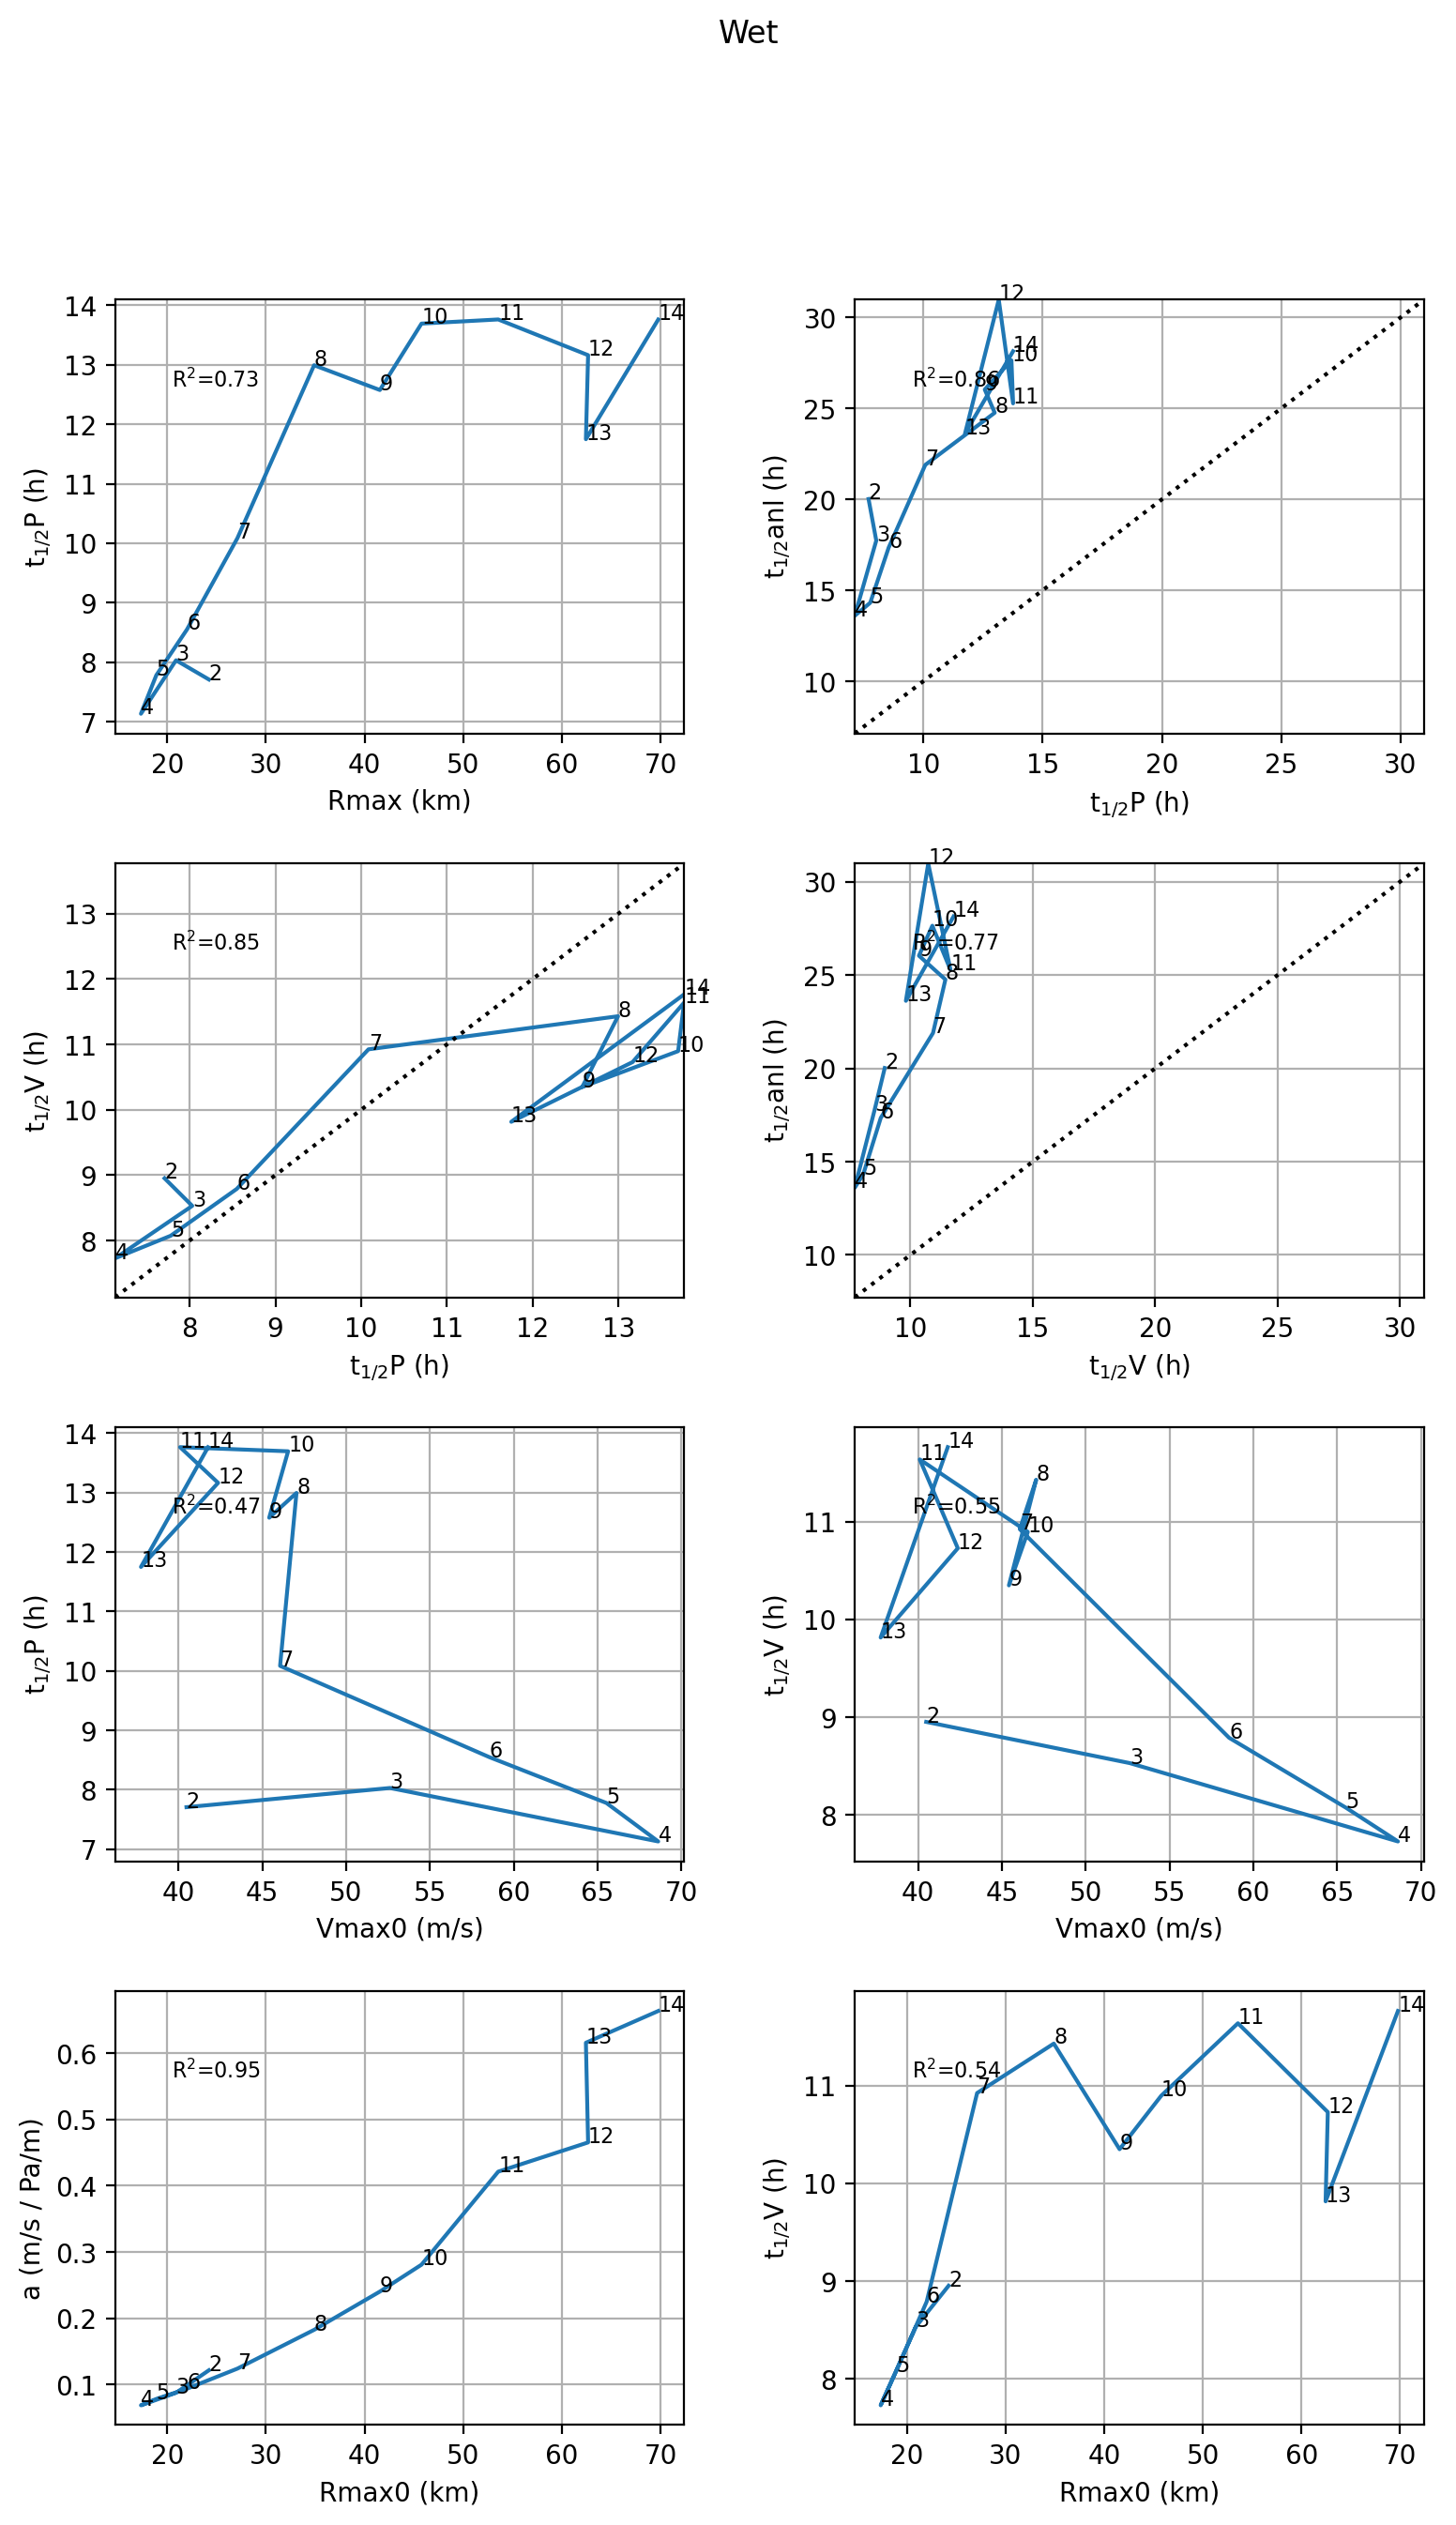

In [246]:
tlfs=df.tlf.unique()
fs=8
fig,axs=plt.subplots(4,2,dpi=200,figsize=(9,15))
plt.subplots_adjust(hspace=0.3,wspace=0.3)

def plot_scat(ax,d):
    ax.plot(d['x'],d['y'])
    ax.grid(True)
    ax.set_ylabel(d['yl'])
    ax.set_xlabel(d['xl'])
    for tlf,x,y in zip(tlfs,d['x'],d['y']):
        ax.text(x,y,round(tlf),fontsize=fs)
    r2=np.corrcoef(d['x'],d['y'])[0,1]**2
    ax.text(0.1,0.8,"R$^2$={:2.2f}".format(r2),transform=ax.transAxes,fontsize=fs)
    if d['eq']:
        axr=(np.min((d['x'],d['y'])),np.max((d['x'],d['y'])))
        ax.plot(axr,axr,':k')
        ax.set_xlim(axr)
        ax.set_ylim(axr)

dd=[{'x':Rmax0,  'xl':'Rmax (km)',      'y':thP,  'yl':'t$_{1/2}$P (h)',    'eq':False},
    {'x':thP,    'xl':'t$_{1/2}$P (h)', 'y':tha,  'yl':'t$_{1/2}$anl (h)',  'eq':True},
    {'x':thP,    'xl':'t$_{1/2}$P (h)', 'y':thV,  'yl':'t$_{1/2}$V (h)',    'eq':True},
    {'x':thV,    'xl':'t$_{1/2}$V (h)', 'y':tha,  'yl':'t$_{1/2}$anl (h)',  'eq':True},
    {'x':Vmax0,  'xl':'Vmax0 (m/s)',    'y':thP,  'yl':'t$_{1/2}$P (h)',    'eq':False},
    {'x':Vmax0,  'xl':'Vmax0 (m/s)',    'y':thV,  'yl':'t$_{1/2}$V (h)',    'eq':False},
    {'x':Rmax0,  'xl':'Rmax0 (km)',     'y':a,  'yl':'a (m/s / Pa/m)',    'eq':False},
    {'x':Rmax0,  'xl':'Rmax0 (km)',     'y':thV,  'yl':'t$_{1/2}$V (h)',    'eq':False},
    
   ]
for ax,d in zip(axs.flatten(),dd):
    plot_scat(ax,d)
plt.suptitle(runstr);

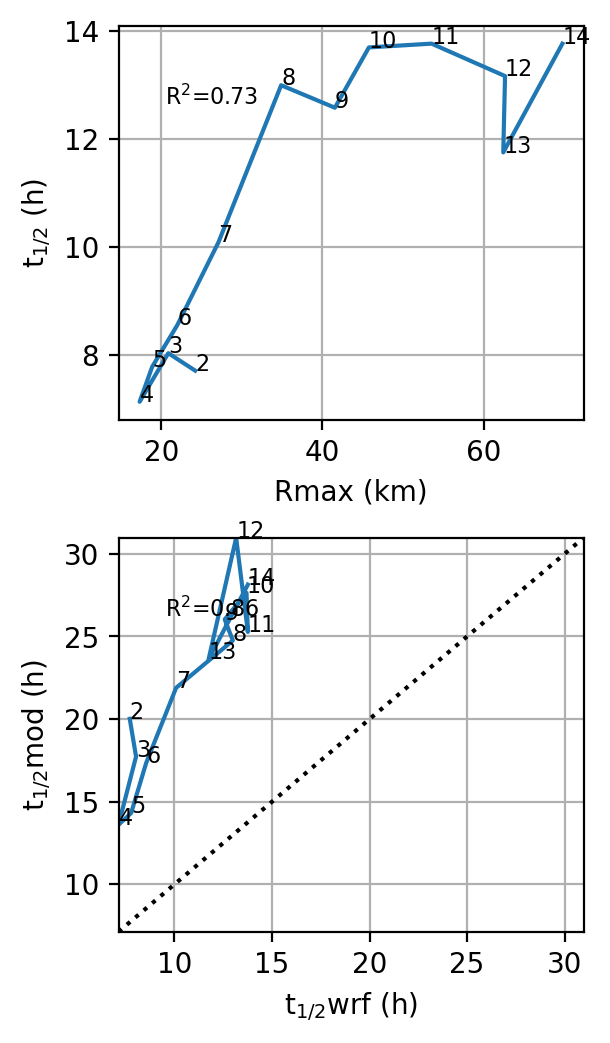

In [247]:
#### tlfs=df.tlf.unique()
fs=8
fig,axs=plt.subplots(2,1,dpi=200,figsize=(3,6))
plt.subplots_adjust(hspace=0.3,wspace=0.3)

def plot_scat(ax,d):
    ax.plot(d['x'],d['y'])
    ax.grid(True)
    ax.set_ylabel(d['yl'])
    ax.set_xlabel(d['xl'])
    for tlf,x,y in zip(tlfs,d['x'],d['y']):
        ax.text(x,y,round(tlf),fontsize=fs)
    r2=np.corrcoef(d['x'],d['y'])[0,1]**2
    ax.text(0.1,0.8,"R$^2$={:2.2f}".format(r2),transform=ax.transAxes,fontsize=fs)
    if d['eq']:
        axr=(np.min((d['x'],d['y'])),np.max((d['x'],d['y'])))
        ax.plot(axr,axr,':k')
        ax.set_xlim(axr)
        ax.set_ylim(axr)

dd=[{'x':Rmax0,  'xl':'Rmax (km)',      'y':thP,  'yl':'t$_{1/2}$ (h)',    'eq':False},
    {'x':thP,    'xl':'t$_{1/2}$wrf (h)', 'y':tha,  'yl':'t$_{1/2}$mod (h)',  'eq':True},
#     {'x':thP,    'xl':'t$_{1/2}$P (h)', 'y':thV,  'yl':'t$_{1/2}$V (h)',    'eq':True},
#     {'x':thV,    'xl':'t$_{1/2}$V (h)', 'y':tha,  'yl':'t$_{1/2}$anl (h)',  'eq':True},
#     {'x':Vmax0,  'xl':'Vmax0 (m/s)',    'y':thP,  'yl':'t$_{1/2}$P (h)',    'eq':False},
#     {'x':Vmax0,  'xl':'Vmax0 (m/s)',    'y':thV,  'yl':'t$_{1/2}$V (h)',    'eq':False},
   ]
for ax,d in zip(axs.flatten(),dd):
    plot_scat(ax,d)
# plt.suptitle(runstr);